In [1]:
# 1. IMPORTS AND SETUP
from datasets import load_dataset
from transformers import BertTokenizer, BertModel
import torch
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import numpy as np
import pandas as pd
import re
import string
from sklearn.metrics import accuracy_score, log_loss, f1_score, recall_score, roc_curve, roc_auc_score, balanced_accuracy_score
from sklearn.model_selection import cross_val_predict, train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sentence_transformers import SentenceTransformer
import random
from cleanlab import Datalab
import seaborn as sns

# Configure device (GPU or CPU)
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS is available on this device")
else:
    device = torch.device("cpu")
    print("MPS is not available, using CPU")

# Set random seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

/Users/linozurmuhl/Library/CloudStorage/OneDrive-HertieSchool/MDS/Master_Thesis_Dogwhistle/dogwhistle_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MPS is available on this device


In [2]:
# Load and inspect the dataset
dataset = load_dataset("SALT-NLP/silent_signals")
print(dataset)

# Convert to pandas dataframe
dataset = dataset["train"]
df = pd.DataFrame(dataset)

# Function to drop duplicates but save those dropped instances in a separate data frame
def drop_duplicates_save(df):
    duplicates = df[df.duplicated(subset=["content"], keep=False)]
    df = df.drop_duplicates(subset=["content"])
    # drop missing values in label and content
    df = df.dropna(subset=["content"])
    if "lable" in df.columns:
        df = df.dropna(subset=["lable"])
    return df, duplicates

# Filter out the informal and formal sentences
df_informal = df[df["type"] == "Informal"]
df_formal = df[df["type"] == "Formal"]
print('With duplicates:', df_informal.shape, df_formal.shape)

# Drop duplicates
df_informal, duplicates_if_1 = drop_duplicates_save(df_informal)
df_formal, duplicates_f_1 = drop_duplicates_save(df_formal)
print('Without duplicates:', df_informal.shape, df_formal.shape)

# Load additional data
null_dataset_formal = pd.read_csv("data/0_data/formal_neg_predictions.csv")
null_dataset_informal = pd.read_csv("data/0_data/informal_neg_predictions.csv")

print('With duplicates:', null_dataset_formal.shape, null_dataset_informal.shape)
# Drop duplicates
null_dataset_informal, duplicates_if_0 = drop_duplicates_save(null_dataset_informal)
null_dataset_formal, duplicates_f_0 = drop_duplicates_save(null_dataset_formal)
print('Without duplicates:', null_dataset_formal.shape, null_dataset_informal.shape)

# Merge datasets
null_dataset = pd.concat([null_dataset_formal, null_dataset_informal])

# Exploratory data analysis
print(null_dataset.info())

Using the latest cached version of the dataset since SALT-NLP/silent_signals couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /Users/linozurmuhl/.cache/huggingface/datasets/SALT-NLP___silent_signals/default/0.0.0/b4a40fb9c0ce49ea9402e67618a5553fac2a26f3 (last modified on Tue Nov  5 10:20:31 2024).


DatasetDict({
    train: Dataset({
        features: ['dog_whistle', 'dog_whistle_root', 'ingroup', 'content', 'date', 'speaker', 'chamber', 'subreddit', 'source', 'definition', 'type', 'party'],
        num_rows: 16258
    })
})
With duplicates: (12923, 12) (3335, 12)
Without duplicates: (12901, 12) (3298, 12)
With duplicates: (33563, 16) (34360, 14)
Without duplicates: (33057, 16) (34212, 14)
<class 'pandas.core.frame.DataFrame'>
Index: 67269 entries, 0 to 34359
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   dog_whistle       67269 non-null  object 
 1   dog_whistle_root  67269 non-null  object 
 2   ingroup           67269 non-null  object 
 3   content           67269 non-null  object 
 4   date              67269 non-null  object 
 5   speaker           33045 non-null  object 
 6   chamber           33057 non-null  object 
 7   community         16 non-null     object 
 8   speech_id         26072

In [4]:
# count number unique values in dog_whistles_root column in df_informal, unique number in ingroup and community
print("Informal dataset unique values in dog_whistles_root column:", df_informal["dog_whistle_root"].nunique())
print("Informal dataset unique values in ingroup column:", df_informal["ingroup"].nunique())
print("Informal dataset unique values in subreddit column:", df_informal["subreddit"].nunique())
print("Length of informal dataset:", len(df_informal))
print("Start date of informal dataset:", df_informal["date"].min())
print("End date of informal dataset:", df_informal["date"].max())

Informal dataset unique values in dog_whistles_root column: 298
Informal dataset unique values in ingroup column: 18
Informal dataset unique values in subreddit column: 47
Length of informal dataset: 12901
Start date of informal dataset: 01/01/2014
End date of informal dataset: 12/31/2022


In [5]:
# count number unique values in dog_whistles_root column in null dtata informal, unique number in ingroup and community
print("Null dataset informal unique values in dog_whistles_root column:", null_dataset_informal["dog_whistle_root"].nunique())
print("Null dataset informal unique values in ingroup column:", null_dataset_informal["ingroup"].nunique())
print("Null dataset informal unique values in subreddit column:", null_dataset_informal["subreddit"].nunique())
print("Length of null dataset informal:", len(null_dataset_informal))
print("Start date of null dataset informal:", null_dataset_informal["date"].min())
print("End date of null dataset informal:", null_dataset_informal["date"].max())

Null dataset informal unique values in dog_whistles_root column: 299
Null dataset informal unique values in ingroup column: 18
Null dataset informal unique values in subreddit column: 39
Length of null dataset informal: 34212
Start date of null dataset informal: 2008-06-03
End date of null dataset informal: 2023-09-08


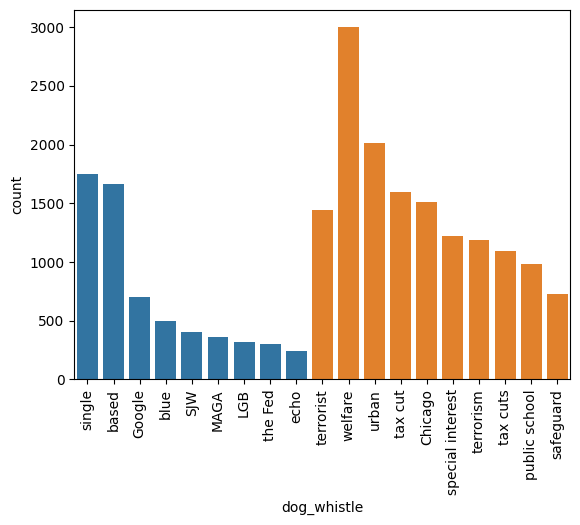

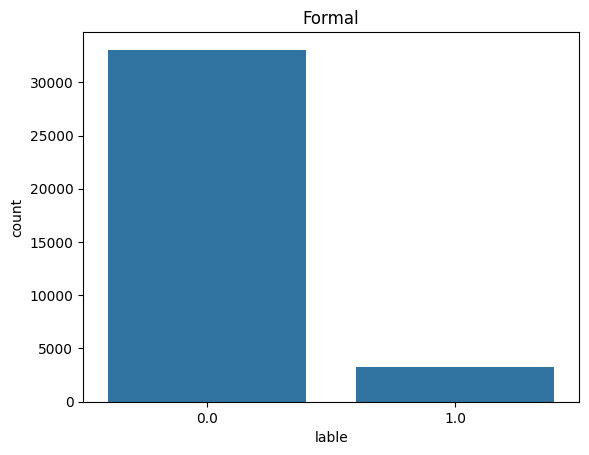

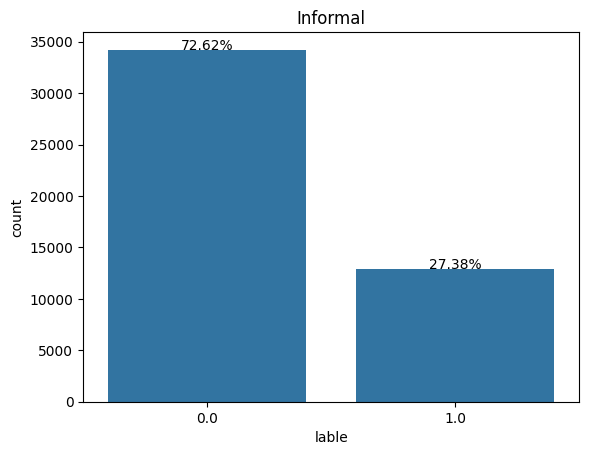

              lable
count  47113.000000
mean       0.273831
std        0.445928
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000


In [3]:
# Count plot of informal dog_whistle and formal dog_whistle
# Top 10 dog whistles
sns.countplot(x='dog_whistle', 
              data=null_dataset_informal, 
              order=null_dataset_informal['dog_whistle'].value_counts().iloc[:10].index)
sns.countplot(x='dog_whistle', 
              data=null_dataset_formal, 
              order=null_dataset_formal['dog_whistle'].value_counts().iloc[:10].index)
plt.xticks(rotation=90)
plt.show()

# Join datasets
df_informal = pd.concat([df_informal, null_dataset_informal])
# Label missing values as 1 in label column
df_informal['lable'] = df_informal['lable'].fillna(1)

# Join null formal data and original formal data
df_formal = pd.concat([df_formal, null_dataset_formal])
# Label missing values as 0 in label column
df_formal['lable'] = df_formal['lable'].fillna(1)

# Count plot label column of informal and formal
sns.countplot(x='lable', data=df_formal)
plt.title('Formal')
plt.show()

ax = sns.countplot(x='lable', data=df_informal)
# Add percentage of each class
total = len(df_informal)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 3, f'{height/total:.2%}', ha="center")

plt.title('Informal')
plt.show()

# Describe the data
print(df_informal.describe())

In [4]:
df_formal.head()

,dog_whistle,dog_whistle_root,ingroup,content,date,speaker,chamber,subreddit,source,definition,type,party,community,speech_id,speaker_bioguide,in_group,lable
2941,welfare,welfare,racist,Very few Americans would disagree that our wel...,03/21/1995,FRANK RIGGS,H,None,Stanford Congressional Record,racial minorities receive government aid that ...,Formal,R,NaN,NaN,NaN,NaN,1.0
2942,tax cut,cut taxes,racist,The Republicans are so mean to kids in this we...,03/23/1995,HAROLD FORD,H,None,Stanford Congressional Record,Don't spend tax money on minorities,Formal,D,NaN,NaN,NaN,NaN,1.0
2943,tax cut,cut taxes,racist,At the same time it supports a plan that would...,02/13/2003,STENY HOYER,H,None,Stanford Congressional Record,Don't spend tax money on minorities,Formal,D,NaN,NaN,NaN,NaN,1.0
2944,tax cut,cut taxes,racist,Well. this tax cut for the wealthy and tax cut...,10/26/1995,XAVIER BECERRA,H,None,Stanford Congressional Record,Don't spend tax money on minorities,Formal,D,NaN,NaN,NaN,NaN,1.0
2945,tax cuts,cut taxes,racist,So we do need to regain some of the lost reven...,03/23/1988,MICHAEL LOWRY,H,None,Stanford Congressional Record,Don't spend tax money on minorities,Formal,D,NaN,NaN,NaN,NaN,1.0


In [5]:
# Extract data for model training
raw_texts = df_informal['content'].tolist()
labels = df_informal['lable'].tolist()
dog_whistles = df_informal['dog_whistle'].tolist()

# Initialize BERT for embeddings
tokenizer = BertTokenizer.from_pretrained('google-bert/bert-base-cased')
model = BertModel.from_pretrained('google-bert/bert-base-cased').to(device)

def get_embeddings_in_batches(texts, batch_size=32):
    all_embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        tokens = tokenizer(
            batch_texts, 
            padding=True, 
            truncation=True, 
            return_tensors='pt', 
            max_length=512
        ).to(device)
        with torch.no_grad():
            outputs = model(**tokens)
            embeddings = outputs.last_hidden_state.mean(dim=1)  # Mean pooling
        all_embeddings.append(embeddings.cpu().numpy())
    return np.concatenate(all_embeddings, axis=0)

# Get embeddings for the dataset
embeddings_np_informal = get_embeddings_in_batches(raw_texts, batch_size=32)

# Define cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=seed)

# Train classifier using cross-validation
clf = LogisticRegression(max_iter=1000, random_state=seed)
pred_probs = cross_val_predict(
    clf, embeddings_np_informal, labels, method="predict_proba", cv=cv
)

5. Data Quality Analysis with Cleanlab

Finding null issues ...
Finding label issues ...
Finding outlier issues ...
Finding near_duplicate issues ...
Finding non_iid issues ...
Finding class_imbalance issues ...
Finding underperforming_group issues ...

Audit complete. 7833 issues found in the dataset.
Dataset Information: num_examples: 47113, num_classes: 2

Here is a summary of various issues found in your data:

    issue_type  num_issues
         label        6525
       outlier        1142
near_duplicate         165
       non_iid           1

Learn about each issue: https://docs.cleanlab.ai/stable/cleanlab/datalab/guide/issue_type_description.html
See which examples in your dataset exhibit each issue via: `datalab.get_issues(<ISSUE_NAME>)`

Data indices corresponding to top examples of each issue are shown below.


----------------------- label issues -----------------------

About this issue:
	Examples whose given label is estimated to be potentially incorrect
    (e.g. due to annotation error) are flagged as having l

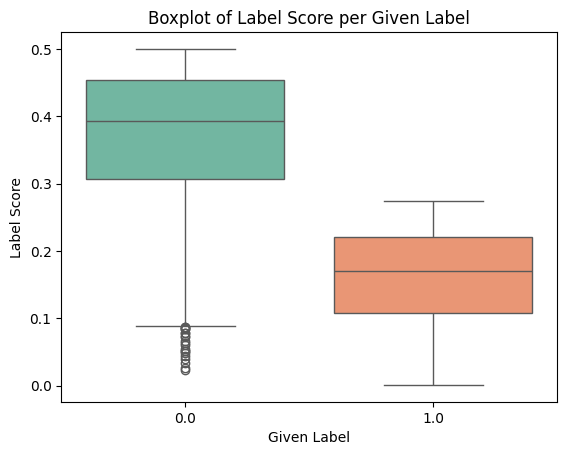

In [6]:
# Use Cleanlab to find and analyze data quality issues
data_dict = {"texts": raw_texts, "labels": labels}
lab = Datalab(data_dict, label_name="labels")
lab.find_issues(pred_probs=pred_probs, features=embeddings_np_informal)
lab.report()

# Extract label issues
label_issues = lab.get_issues("label")
identified_label_issues = label_issues[label_issues["is_label_issue"] == True]

# Create dataframe with suggested labels
data_with_suggested_labels = pd.DataFrame({
    "dog_whistles": dog_whistles, 
    "text": raw_texts, 
    "given_label": labels, 
    "suggested_label": label_issues["predicted_label"], 
    "problem": identified_label_issues["is_label_issue"], 
    "label_score": identified_label_issues["label_score"]
})
potential_wrong_label = data_with_suggested_labels.dropna(subset=["problem"]).sort_values(by="label_score", ascending=False)

# Save potential wrong labels for review
potential_wrong_label.to_csv("data/vetting_instances/potential_wrong_label_new.csv")

# Visualize label score distribution by given label
sns.boxplot(x='given_label', y='label_score', data=potential_wrong_label, palette='Set2')
plt.title('Boxplot of Label Score per Given Label')
plt.xlabel('Given Label')
plt.ylabel('Label Score')
plt.savefig('boxplot_label_score_per_given_label.png')
plt.show()

In [ ]:
# extract near duplicates
near_duplicate = lab.get_issues("near_duplicate")

# Create dataframe with outliers and text from lab based on index so filter out the non outliers

near_duplicate_df = pd.DataFrame({
    "dog_whistles": dog_whistles, 
    "text": raw_texts, 
    "given_label": labels,
    "problem": near_duplicate["is_near_duplicate_issue"],
    "near_duplicate_score": near_duplicate["near_duplicate_score"],
    "sets": near_duplicate["near_duplicate_sets"],
})
near_duplicate_df = near_duplicate_df[near_duplicate_df["problem"] == True]

6. Label Review and Correction

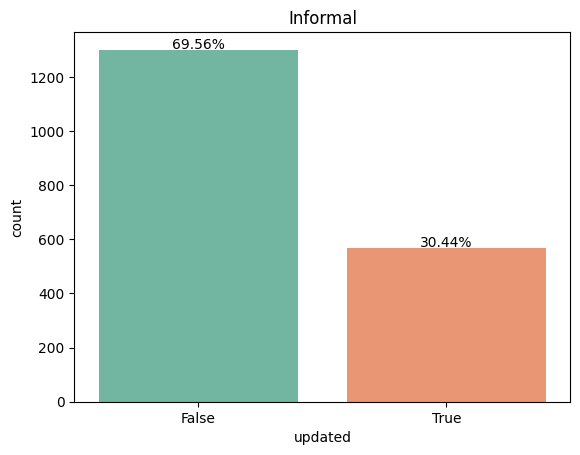

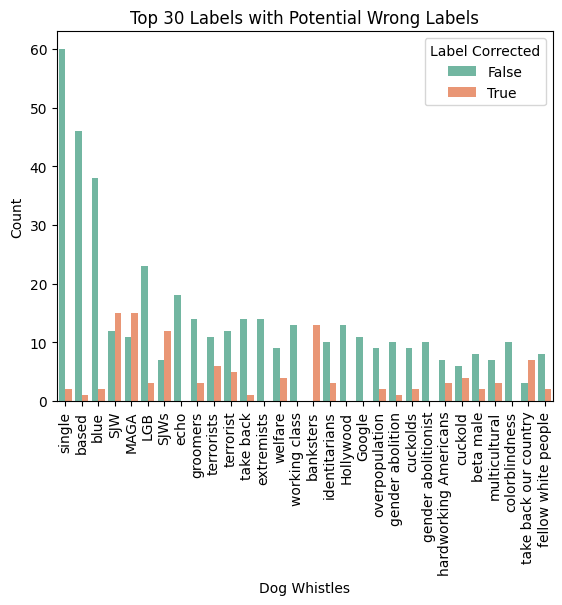

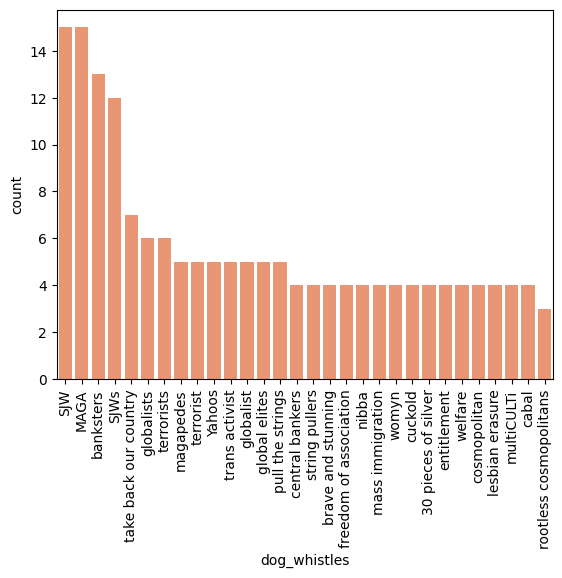

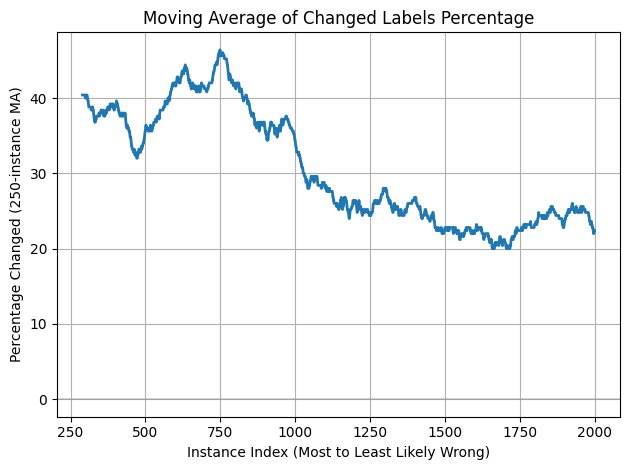

In [12]:
# Load manually reviewed labels
reviewed_labels = pd.read_csv('data/vetting_instances/reviewed_labels.csv')

# Remove instances marked for removal
reviewed_labels = reviewed_labels[~reviewed_labels['reviewer_notes'].str.contains('remove', case=False, na=False)]
# Remove instances marked as unsure usure Unsure
reviewed_labels = reviewed_labels[~reviewed_labels['reviewer_notes'].str.contains('unsure|usure', case=False, na=False)]
# Count labels that were changed during review
reviewed_labels['updated'] = reviewed_labels['given_label'] != reviewed_labels['final_label']
ax = sns.countplot(x='updated', data=reviewed_labels, palette='Set2')
total = len(reviewed_labels)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 3, f'{height/total:.2%}', ha="center")
plt.title('Informal')
plt.show()

# Analyze updated labels by dog whistle type
sns.countplot(x='dog_whistles', data=reviewed_labels, 
              hue='updated', 
              order=reviewed_labels['dog_whistles'].value_counts().iloc[:30].index, 
              palette='Set2')
plt.xticks(rotation=90)
plt.xlabel('Dog Whistles')
plt.ylabel('Count')
plt.legend(title='Label Corrected')
plt.title('Top 30 Labels with Potential Wrong Labels')
plt.savefig('top_20_labels_with_potential_wrong_labels.png', bbox_inches='tight')
plt.show()

# Most updated dog whistles
updated_dog_whistles = reviewed_labels[reviewed_labels['updated'] == True]
sns.countplot(x='dog_whistles', 
              data=updated_dog_whistles, 
              order=updated_dog_whistles['dog_whistles'].value_counts().iloc[:30].index, 
              color='#fc8d62')
plt.xticks(rotation=90)
plt.show()

# Analyze moving average of changed labels
changed_labels = reviewed_labels['updated'].rolling(window=250).mean() * 100
plt.plot(changed_labels, linewidth=2)
plt.title('Moving Average of Changed Labels Percentage')
plt.xlabel('Instance Index (Most to Least Likely Wrong)')
plt.ylabel('Percentage Changed (250-instance MA)')
plt.grid(True)
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()

7. Creating the Corrected Dataset

In [28]:
# Load potential wrong labels
potential_wrong_label = pd.read_csv('data/vetting_instances/potential_wrong_label.csv')

# Drop reviewed instances from potential wrong labels list
potential_wrong_label = potential_wrong_label[~potential_wrong_label['text'].isin(reviewed_labels['text'])]

df_informal = df_informal.reset_index(drop=True)

# Merge the reviewed labels with the informal dataset
df_informal_reviewed = df_informal.merge(
    reviewed_labels.rename(columns={'text': 'content', 'given_label': 'lable'})[['content', 'lable', 'final_label']],
    on='content',
    how='left'
)
print(df_informal_reviewed.index.duplicated().sum())

df_informal_reviewed['lable_x'] = df_informal_reviewed['final_label'].combine_first(df_informal_reviewed['lable_x'])
df_informal_reviewed = df_informal_reviewed.drop(columns=['lable_y', 'final_label'])
df_informal_reviewed = df_informal_reviewed.rename(columns={'lable_x': 'lable'})


# Reassign 'date' and 'subreddit' from the original dataset
df_informal_reviewed['date'] = df_informal['date']
df_informal_reviewed['subreddit'] = df_informal['subreddit']
# Remove instances that are still in the potential wrong label list 
df_informal_reviewed = df_informal_reviewed[~df_informal_reviewed['content'].isin(potential_wrong_label['text'])]

# Remove instances near duplicates
df_informal_reviewed = df_informal_reviewed[~df_informal_reviewed['content'].isin(near_duplicate_df['text'])]

# Calculate percentage of positive labels
print("Percentage of positive labels:", df_informal_reviewed['lable'].mean())

# Save the corrected dataset
df_informal_reviewed.to_csv('data/informal_reviewed.csv', index=False)

0
Percentage of positive labels: 0.23677433074214965


8. Model Training with Corrected Labels

In [29]:
# Train and evaluate a model with corrected labels
raw_texts_updated = df_informal_reviewed['content'].tolist()
labels_updated = df_informal_reviewed['lable'].tolist()

# Get embeddings for the corrected dataset
embeddings_np_informal_updated = get_embeddings_in_batches(raw_texts_updated, batch_size=32)

# Split into train and test sets
X_train_updated, X_test_updated, y_train_updated, y_test_updated = train_test_split(
    embeddings_np_informal_updated, labels_updated, test_size=0.2, random_state=seed
)

# Train a model on the corrected dataset
clf_updated = LogisticRegression(max_iter=1000, random_state=seed)
clf_updated.fit(X_train_updated, y_train_updated)
y_pred_updated = clf_updated.predict(X_test_updated)

# Calculate performance metrics
print('Balanced accuracy score:', balanced_accuracy_score(y_test_updated, y_pred_updated))
print('F1 score:', f1_score(y_test_updated, y_pred_updated))
print('Recall score:', recall_score(y_test_updated, y_pred_updated))

# Compare with model trained on original dataset
X_train, X_test, y_train, y_test = train_test_split(
    embeddings_np_informal, labels, test_size=0.2, random_state=seed
)

clf = LogisticRegression(max_iter=1000, random_state=seed)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Original model balanced accuracy:', balanced_accuracy_score(y_test, y_pred))
print('Original model F1 score:', f1_score(y_test, y_pred))
print('Original model recall score:', recall_score(y_test, y_pred))

Balanced accuracy score: 0.808001408751494
F1 score: 0.7246891651865008
Recall score: 0.6816229116945107
Original model balanced accuracy: 0.6695076976732939
Original model F1 score: 0.5144308473793581
Original model recall score: 0.43329443796188255


9. Model Comparison and ROC Curve Visualization

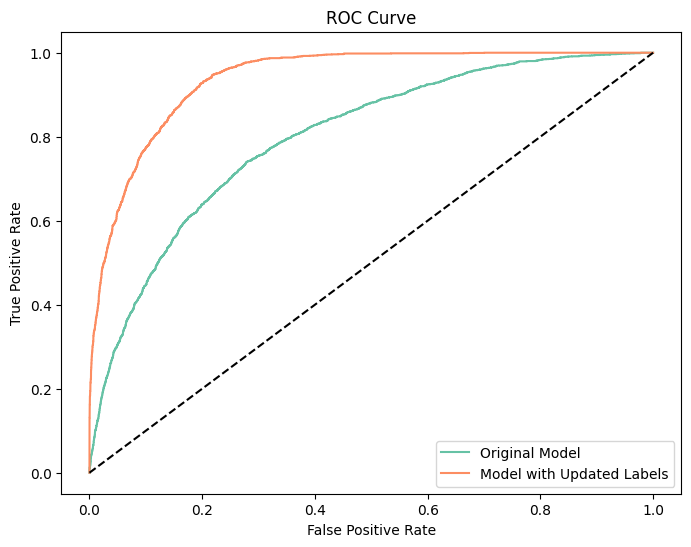

Original Model
              precision    recall  f1-score   support

         0.0       0.81      0.91      0.86      6852
         1.0       0.63      0.43      0.51      2571

    accuracy                           0.78      9423
   macro avg       0.72      0.67      0.68      9423
weighted avg       0.76      0.78      0.76      9423

Model with Updated Labels
              precision    recall  f1-score   support

         0.0       0.90      0.93      0.92      6370
         1.0       0.77      0.68      0.72      2095

    accuracy                           0.87      8465
   macro avg       0.84      0.81      0.82      8465
weighted avg       0.87      0.87      0.87      8465



In [30]:
# Compare ROC curves for original and corrected models
fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
fpr_updated, tpr_updated, _ = roc_curve(y_test_updated, clf_updated.predict_proba(X_test_updated)[:,1])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Original Model', color='#66c2a5')
plt.plot(fpr_updated, tpr_updated, label='Model with Updated Labels', color='#fc8d62')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.savefig('roc_curve.png')
plt.show()

# Print detailed classification reports
from sklearn.metrics import classification_report
print('Original Model')
print(classification_report(y_test, y_pred))
print('Model with Updated Labels')
print(classification_report(y_test_updated, y_pred_updated))

10. External Validation

In [27]:
# Load external validation dataset
test_dataset = load_dataset("SALT-NLP/silent_signals_detection")
test_dataset = test_dataset['train']
test_df = pd.DataFrame(test_dataset)

# Generate predictions
test_raw_texts = test_df['example'].tolist()
test_embeddings = get_embeddings_in_batches(test_raw_texts, batch_size=32)
test_labels = clf_updated.predict(test_embeddings)

# Add predictions to dataframe and evaluate
test_df['label_pred'] = test_labels
test_df['label'] = test_df['label'].apply(lambda x: 1 if x == 'coded' else 0)
accuracy = accuracy_score(test_df['label'], test_df['label_pred'])
print("External validation accuracy:", accuracy)
print(classification_report(test_df['label'], test_df['label_pred']))

External validation accuracy: 0.48514851485148514
              precision    recall  f1-score   support

           0       0.49      0.98      0.65        50
           1       0.00      0.00      0.00        51

    accuracy                           0.49       101
   macro avg       0.24      0.49      0.33       101
weighted avg       0.24      0.49      0.32       101



In [6]:
CSV_PATH = 'data/informal_reviewed.csv'
VAL_SIZE = 0.1

print(f"Loading data from: {CSV_PATH}")
df = pd.read_csv(CSV_PATH)

# Handle different label column names
if 'lable' in df.columns:
    df.rename(columns={'lable': 'label'}, inplace=True)
elif 'label' not in df.columns:
    raise ValueError("CSV must contain either 'lable' or 'label' column")

# Ensure label is integer
df['label'] = df['label'].astype(int)

required_columns = ['content', 'definition', 'label']
if not all(col in df.columns for col in required_columns):
    raise ValueError(f"CSV must contain columns: {required_columns}")

train_df, val_df = train_test_split(
    df,
    test_size=VAL_SIZE,
    random_state=seed,
    stratify=df['label']
)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")

# RoBERTa only needs content and label
roberta_train = train_df[['content', 'label']].copy()
roberta_val = val_df[['content', 'label']].copy()

roberta_train.to_csv('data/roberta_train.csv', index=False)
roberta_val.to_csv('data/roberta_val.csv', index=False)

# Format prompt for Gemma
def format_prompt(row):
    return f"""You are a helpful assistant participating in a content moderation task of dog whistle detection. A dogwhistle is the use of coded or suggestive language in political messaging to garner support from a particular group without provoking opposition. Does the following sentence contain a dog whistle? {row['content']}"""

# Create Gemma versions with prompts
gemma_train = train_df.copy()
gemma_val = val_df.copy()

gemma_train['text'] = gemma_train.apply(format_prompt, axis=1)
gemma_val['text'] = gemma_val.apply(format_prompt, axis=1)

# Select only needed columns for Gemma
gemma_train = gemma_train[['content', 'label']]
gemma_val = gemma_val[['content', 'label']]

gemma_train.to_csv('data/gemma_train.csv', index=False)
gemma_val.to_csv('data/gemma_val.csv', index=False)

print("\nData Statistics:")
print(f"Total examples: {len(df)}")
print(f"Label distribution in full dataset:")
print(df['label'].value_counts(normalize=True))
print(f"\nLabel distribution in training set:")
print(train_df['label'].value_counts(normalize=True))
print(f"\nLabel distribution in validation set:")
print(val_df['label'].value_counts(normalize=True))

Loading data from: data/informal_reviewed.csv
Training set size: 38090
Validation set size: 4233

Data Statistics:
Total examples: 42323
Label distribution in full dataset:
label
0    0.763226
1    0.236774
Name: proportion, dtype: float64

Label distribution in training set:
label
0    0.763219
1    0.236781
Name: proportion, dtype: float64

Label distribution in validation set:
label
0    0.763288
1    0.236712
Name: proportion, dtype: float64
